In [82]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def rbf_kernel(x, sigma=1):
    '''
    
    '''
    nrow, ncol = np.shape(x)
    k = np.matmul(x, np.transpose(x)) / (sigma ** 2)
    d = np.diag(k)
    # subtract diagonal one time as a row and once as a column
    k1 = k - (d.reshape(-1, 1) / (2 * (sigma ** 2)))
    k2 = k1 - (d.reshape(1, -1) / (2 * (sigma ** 2)))
    k3 = np.exp(k2)
    return k3


def rbf_n_white_kernel(ɾ, λ, σ):
    return (ɾ**2 * gp.kernels.RBF(length_scale=λ) + gp.kernels.WhiteKernel(noise_level=σ))


In [25]:
def generate_priors(k, n, num_func):
    '''
    
    '''
    L = np.linalg.cholesky(k + np.exp(-6) * np.eye(n))
    f_prior = np.dot(L, np.random.normal(size=(n, num_func)))
    return f_prior.reshape(num_func, -1)

In [26]:
x = np.linspace(-5, 5, 20).reshape(-1, 1)
k = rbf_kernel(x)
f_prior = generate_priors(k, 20, 1000)

In [104]:
def create_batch_gp_mim(enc_tr, dec_tr, y_tr, batch_s=128):
    '''
    
    '''
    shape = enc_tr.shape[0]
    timestamps = enc_tr.shape[1]
    feat = enc_tr.shape[2]
    batch_idx_tr = np.random.choice(list(range(shape)), batch_s)
    batch_enc_tr = (enc_tr[batch_idx_tr, :, :].reshape(batch_s, timestamps, feat))
    batch_dec_tr = dec_tr[batch_idx_tr]
    batch_y_tr = (y_tr[batch_idx_tr].reshape(-1, 1))
    return batch_enc_tr, batch_dec_tr, batch_y_tr, batch_idx_tr

In [211]:
def plot_gp_prior(num_func, data=None, n=50):
    '''
    
    
    '''
    if (data):
        x_te = data
        n = len(x_te)
    else:
        x_te = np.linspace(-5, 5, n).reshape(-1, 1)
    k = rbf_kernel(x_te)
    f_prior = generate_priors(k, n, num_func)
    with matplotlib.rc_context({'figure.figsize': [12, 5]}):
        for idx, func in enumerate(f_prior):
            plt.plot(x_te, func, label='f' + str(idx))
        plt.xlabel('X')
        plt.ylabel('fi(X) = y')
        plt.title('Prior functions drawn from Gausian distribution')
        plt.legend()
        plt.show()


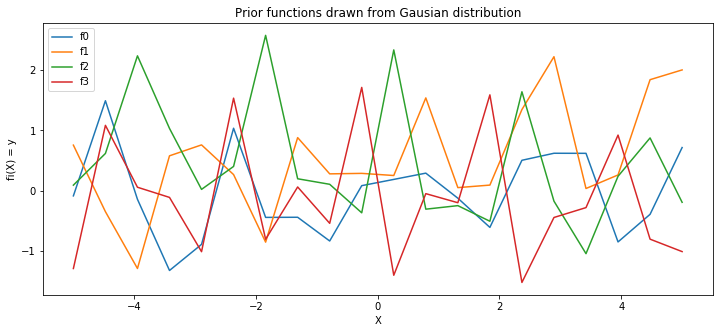

In [212]:
plot_gp_prior(4, n=20)

In [57]:
df = np.zeros((500, 20))
for i in range(0, 500, 2):
    x = np.random.uniform(-5, 5, size = (1, 20))
    k = rbf_kernel(x)
    f_prior = generate_priors(k, 20, 1)
    
    df[i, :] = x
    df[i + 1, :] = f_prior

rows = df.shape[0]
tr_rows = int(0.8 * rows) if int(0.8 * rows) % 2 == 0 else int(0.8 * rows) + 1  
df_tr = df[:tr_rows, :]
df_te = df[tr_rows:, :]

eng_tr = df_tr[:tr_rows, :(cols - 1)] ; eng_te = df_te[:, :(cols - 1)]
fren_tr = df_tr[::2, cols - 1] ; fren_te = df_te[::2, cols - 1]
y_fren_tr = df_tr[1::2, cols - 1] ; y_fren_te = df_te[1::2, cols - 1]


In [169]:
### Simple attention 

In [81]:
eng_tr = eng_tr.T.reshape(-1, 19, 2)

In [89]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [90]:
encoder = Encoder(32, 128)

In [91]:
sample_hidden = encoder.initialize_hidden_state()

In [92]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, decoder_hidden, encoder_out):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(decoder_hidden_with_time_axis) + self.W2(encoder_out)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * encoder_out
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [93]:
attention_layer = BahdanauAttention(10)

In [94]:
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(1)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)


        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [96]:
decoder = Decoder(32, 128)

In [98]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.mean_squared_error

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Casts a tensor to a new type.
    mask = tf.cast(mask, dtype=loss_.dtype)
    # equivalent to element-wise multiplication 
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [105]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(optimizer=optimizer,
#                                  encoder=encoder,
#                                  decoder=decoder)

In [106]:
# french_tr is the input to decoder
# 
@tf.function
def train_step(eng_tr, fren_tr, y_fren_tr, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(eng_tr, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([fren_tr], 1)

        # Teacher forcing - feeding the target as the next input
#         for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
          # pay attention that the decoder returns a new dec_hidden (which is the state of the GRU)
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(y_fren_tr, predictions)

            # using teacher forcing
#             dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(y_fren_tr.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [107]:
batch_loss = tf.keras.metrics.Mean(name='batch_loss')

In [109]:
tf.keras.backend.set_floatx('float64')

In [108]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    batch_loss.reset_states()


    enc_hidden = encoder.initialize_hidden_state()

    for i in range(10):
        b_eng_tr, b_fren_tr, b_y_fren_tr, _ = create_batch_gp_mim(eng_tr, fren_tr, y_fren_tr)
        train_step(eng_tr, fren_tr, y_fren_tr, sample_hidden)

    if i % 5 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   i,
                                                   batch_loss.numpy()))
#     # saving (checkpoint) the model every 2 epochs
#     if (epoch + 1) % 2 == 0:
#         checkpoint.save(file_prefix = checkpoint_prefix)

#     print('Epoch {} Loss {:.4f}'.format(epoch + 1,
#                                       total_loss / steps_per_epoch))
#     print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



ValueError: in user code:

    <ipython-input-106-96298b4ce289>:8 train_step  *
        enc_output, enc_hidden = encoder(eng_tr, enc_hidden)
    <ipython-input-89-ce4d2d84e84d>:12 call  *
        output, state = self.gru(x, initial_state = hidden)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:707 __call__  **
        return super(RNN, self).__call__(inputs, **kwargs)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:433 call
        zero_output_for_mask=self.zero_output_for_mask)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4092 rnn
        input_time_zero, tuple(initial_states) + tuple(constants))
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:421 step
        return self.cell(cell_inputs, cell_states, **kwargs)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:1867 call
        z = self.recurrent_activation(x_z + recurrent_z)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1276 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:483 add_v2
        "AddV2", x=x, y=y, name=name)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 200 and 128 for '{{node encoder_3/gru_1/gru_cell_1/add}} = AddV2[T=DT_FLOAT](encoder_3/gru_1/gru_cell_1/split, encoder_3/gru_1/gru_cell_1/split_1)' with input shapes: [200,32], [128,32].


In [38]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /Users/omernivron/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCN89RD/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /Users/omernivron/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCN89RD/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /Users/omernivron/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCN89RD/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /Users/omernivron/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [39]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [102]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [41]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [42]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [43]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
    return lang1, lang2

In [44]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [45]:
MAX_LENGTH = 40

In [46]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [47]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [49]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

In [50]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [51]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [52]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

(1, 50, 512)


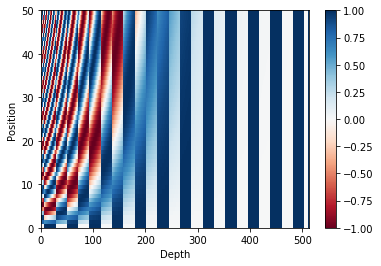

In [53]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
# the mask indicates which entries should not be used.

In [54]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [55]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [56]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [57]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [58]:
x

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.25745153, 0.22060382, 0.59445953]], dtype=float32)>

In [60]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [61]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [62]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [63]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [64]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [135]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        
#         print('value: ', v)
#         print('key: ', k)
#         print('query: ', q)
        
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [105]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

value:  tf.Tensor(
[[[0.93007994 0.07386124 0.12029994 ... 0.7008438  0.0717392  0.26032686]
  [0.48606646 0.7353846  0.41520226 ... 0.35724092 0.27602732 0.86372983]
  [0.41987157 0.8600621  0.10850787 ... 0.467916   0.99416685 0.17329168]
  ...
  [0.12135828 0.24125612 0.59066045 ... 0.6352788  0.778121   0.11662745]
  [0.4706217  0.46683395 0.69353175 ... 0.56884396 0.90624857 0.3799808 ]
  [0.5592438  0.9700223  0.72765493 ... 0.13796568 0.9331293  0.17192411]]], shape=(1, 60, 512), dtype=float32)
key:  tf.Tensor(
[[[0.93007994 0.07386124 0.12029994 ... 0.7008438  0.0717392  0.26032686]
  [0.48606646 0.7353846  0.41520226 ... 0.35724092 0.27602732 0.86372983]
  [0.41987157 0.8600621  0.10850787 ... 0.467916   0.99416685 0.17329168]
  ...
  [0.12135828 0.24125612 0.59066045 ... 0.6352788  0.778121   0.11662745]
  [0.4706217  0.46683395 0.69353175 ... 0.56884396 0.90624857 0.3799808 ]
  [0.5592438  0.9700223  0.72765493 ... 0.13796568 0.9331293  0.17192411]]], shape=(1, 60, 512), dty

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [106]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [107]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [108]:
# The input sentence is passed through N encoder layers 
# that generates an output for each word/token in the sequence.

# The decoder attends on the encoder's output and
# its own input (self-attention) to predict the next word.


In [109]:
# Encoder layer

# Each encoder layer consists of sublayers:

# Multi-head attention (with padding mask)
# Point wise feed forward networks.

In [110]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [136]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [112]:
# Decoder layer

# Each decoder layer consists of sublayers:

# Masked multi-head attention (with look ahead mask and padding mask)
# Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
# Point wise feed forward networks

In [137]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [138]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [139]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
#         print('encoder_x_inp: ', x)
#         print('encoder_mask: ', mask)

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
#         print('encoded_x_after_embedding: ', x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [140]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [308]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    #a call method, the layer's forward pass
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [142]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [143]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [144]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [145]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [146]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

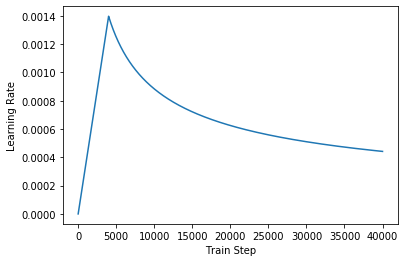

In [147]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [148]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')



In [149]:
# Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [150]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [151]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [152]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [153]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [154]:
# Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.


checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [155]:
# The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. 
# tar_real is that same input shifted by 1: 
#     At each location in tar_input, tar_real contains the next token that should be predicted.

In [156]:
# For example, sentence = "SOS A lion in the jungle is sleeping EOS"

# tar_inp = "SOS A lion in the jungle is sleeping"

# tar_real = "A lion in the jungle is sleeping EOS"

In [157]:
# Teacher forcing is passing the true output to the next time step
# regardless of what the model predicts at the current time step.

In [158]:
# To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [159]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    print('enc_padding_mask: ', enc_padding_mask)
    print('dec_padding_mask: ', dec_padding_mask)



    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [162]:
EPOCHS = 1

In [166]:
inp[0, :]

<tf.Tensor: shape=(37,), dtype=int64, numpy=
array([8214,   42,    8,  131, 3491, 7990,  155,    2, 8215,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])>

In [167]:
tar[0, :]

<tf.Tensor: shape=(38,), dtype=int64, numpy=
array([8087,   16,   13,   18, 7375,  492,  111,    2, 8088,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>

In [165]:
inp[1, :]

<tf.Tensor: shape=(37,), dtype=int64, numpy=
array([8214,   32, 7095,  136,   72,   95,    3, 5768, 8072, 8003,   16,
         22, 6014, 7990,    6,  400,    3, 2155, 8055,   93,  125,   11,
          3, 2637,    1, 1837, 7106,  232,    1,  500,   14, 1944,   37,
       8215,    0,    0,    0])>

In [168]:
tar[1, :]

<tf.Tensor: shape=(38,), dtype=int64, numpy=
array([8087,   62, 3257, 5032, 7863,   20,  114, 6540, 7863,   11, 3029,
          1,    4,   65,  298,    5,  197, 3802,  116,  190,    8,    9,
        120,    5, 1763,  231, 7012, 6455, 5112,    1, 1515,  403,   75,
       8088,    0,    0,    0,    0])>

In [163]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        print('inp: ', inp)
        print('tar: ', tar)
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

inp:  tf.Tensor(
[[8214    9 1356 ...    0    0    0]
 [8214   77   42 ...    0    0    0]
 [8214  610 8003 ...  589 8215    0]
 ...
 [8214   64 7265 ...    0    0    0]
 [8214   78   16 ...    0    0    0]
 [8214   27 1389 ...    0    0    0]], shape=(64, 38), dtype=int64)
tar:  tf.Tensor(
[[8087    7  855 ...    0    0    0]
 [8087   18   16 ...    0    0    0]
 [8087  229   81 ... 8088    0    0]
 ...
 [8087   14  134 ...    0    0    0]
 [8087  115   44 ...    0    0    0]
 [8087   12   20 ...    0    0    0]], shape=(64, 39), dtype=int64)
Epoch 1 Batch 0 Loss 8.9562 Accuracy 0.0008
inp:  tf.Tensor(
[[8214    7 1591 ...    0    0    0]
 [8214 5130  180 ...    0    0    0]
 [8214   56  131 ...    0    0    0]
 ...
 [8214    8 6487 ...    0    0    0]
 [8214 1455  543 ...    0    0    0]
 [8214   24  402 ...    0    0    0]], shape=(64, 38), dtype=int64)
tar:  tf.Tensor(
[[8087 1173 1493 ...    0    0    0]
 [8087  134   16 ...    0    0    0]
 [8087   17   20 ... 8088    0    0]
 ..

inp:  tf.Tensor(
[[8214  229    4 ...    0    0    0]
 [8214   13  324 ...    0    0    0]
 [8214  195    1 ...    0    0    0]
 ...
 [8214   46  174 ...    0    0    0]
 [8214  194    1 ...    0    0    0]
 [8214   12  954 ...    0    0    0]], shape=(64, 35), dtype=int64)
tar:  tf.Tensor(
[[8087   14   90 ...    0    0    0]
 [8087   64   20 ...    0    0    0]
 [8087  803    1 ...    0    0    0]
 ...
 [8087   18   64 ...    0    0    0]
 [8087   18 6985 ...    0    0    0]
 [8087    3 1040 ...    0    0    0]], shape=(64, 33), dtype=int64)
inp:  tf.Tensor(
[[8214   67   92 ... 6703    2 8215]
 [8214 1830    5 ...    0    0    0]
 [8214   47   66 ...    0    0    0]
 ...
 [8214  282  210 ...    0    0    0]
 [8214   54   56 ...    0    0    0]
 [8214    6   14 ...    2 8215    0]], shape=(64, 38), dtype=int64)
tar:  tf.Tensor(
[[8087   94  119 ...    2 8088    0]
 [8087   25   70 ...    0    0    0]
 [8087   66   25 ...    0    0    0]
 ...
 [8087   12  333 ...    0    0    0]
 [808

inp:  tf.Tensor(
[[8214 5893   57 ...    0    0    0]
 [8214    7    5 ...    0    0    0]
 [8214    8  347 ...    0    0    0]
 ...
 [8214   25 3217 ...    0    0    0]
 [8214   25  140 ...    0    0    0]
 [8214   64   76 ...    0    0    0]], shape=(64, 35), dtype=int64)
tar:  tf.Tensor(
[[8087 2405   77 ...    0    0    0]
 [8087  196    8 ...    0    0    0]
 [8087    6  278 ...    0    0    0]
 ...
 [8087   23   12 ...    0    0    0]
 [8087   23   11 ...    0    0    0]
 [8087   14   31 ...    0    0    0]], shape=(64, 37), dtype=int64)
inp:  tf.Tensor(
[[8214 2685   79 ...    0    0    0]
 [8214   54    8 ...    0    0    0]
 [8214  191 5079 ...    0    0    0]
 ...
 [8214  568 8003 ...    0    0    0]
 [8214   42 1965 ...    0    0    0]
 [8214    5 1092 ...    0    0    0]], shape=(64, 39), dtype=int64)
tar:  tf.Tensor(
[[8087   14   97 ...    0    0    0]
 [8087   16   13 ...    0    0    0]
 [8087   18  255 ...    0    0    0]
 ...
 [8087   14   22 ...    0    0    0]
 [808

KeyboardInterrupt: 

In [ ]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
  
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [101]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: 
Real translation: this is a problem we have to solve .


In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


In [18]:
# Every v1.Session.run call should be replaced by a Python function.
# The feed_dict and v1.placeholders become function arguments.
# The fetches become the function's return value.
# After that add a tf.function decorator to make it run efficiently in graph. 